In [88]:
import pandas as pd
import numpy as np
from math import  log,pow
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from datetime import datetime

import torch
import torch.nn as nn
from models import LSTNet
import importlib

from utils import *;
import Optim
%matplotlib inline
#显示中文
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

data_path='D:/Codes/nCov/LSTNet-master/total_data/'

In [79]:
inputfile="D:/Codes/nCov/data/out_increase_province_2.26.csv"

# 显示所有列
pd.set_option('display.max_columns', None)
# 显示所有行
pd.set_option('display.max_rows', None)
# 设置value的显示长度为100，默认为50
pd.set_option('max_colwidth', 200)

#读取数据
dataf = pd.read_csv(inputfile, encoding='UTF-8')
print(dataf)

      Unnamed: 0   新增死亡    新增治愈     新增确诊          日期         省     省死亡  \
0              0   52.0  1986.0    401.0  2020-02-26       湖北省  2615.0   
1            381   68.0  2223.0    499.0  2020-02-25       湖北省  2563.0   
2            771  149.0  1405.0    203.0  2020-02-24       湖北省  2495.0   
3           1185   96.0  1653.0    630.0  2020-02-23       湖北省  2346.0   
4           1613  106.0  1809.0    792.0  2020-02-22       湖北省  2250.0   
5           2022  115.0  1360.0    631.0  2020-02-21       湖北省  2144.0   
6           2451  108.0  1185.0    349.0  2020-02-20       湖北省  2029.0   
7           2874  132.0  1393.0   1693.0  2020-02-19       湖北省  1921.0   
8           3301   93.0  1250.0   1807.0  2020-02-18       湖北省  1789.0   
9           3729  100.0  1027.0   1933.0  2020-02-17       湖北省  1696.0   
10          4154  139.0   845.0   1843.0  2020-02-16       湖北省  1596.0   
11          4569   31.0   690.0   2420.0  2020-02-15       湖北省  1457.0   
12          4995  116.0   672.0   3780

             日期     省确诊
339  2020-01-24    43.0
338  2020-01-25    62.0
337  2020-01-26   104.0
336  2020-01-27   128.0
335  2020-01-28   173.0
334  2020-01-29   296.0
333  2020-01-30   428.0
332  2020-01-31   538.0
331  2020-02-01   599.0
330  2020-02-02   661.0
329  2020-02-03   724.0
328  2020-02-04   829.0
327  2020-02-05   895.0
326  2020-02-06   954.0
325  2020-02-07  1006.0
324  2020-02-08  1048.0
323  2020-02-09  1075.0
322  2020-02-10  1092.0
321  2020-02-11  1117.0
320  2020-02-12  1131.0
319  2020-02-13  1145.0
318  2020-02-14  1155.0
317  2020-02-15  1162.0
316  2020-02-16  1167.0
315  2020-02-17  1171.0
314  2020-02-18  1172.0
313  2020-02-19  1174.0
312  2020-02-20  1175.0
311  2020-02-21  1203.0
310  2020-02-22  1205.0
309  2020-02-23  1205.0
308  2020-02-24  1205.0
307  2020-02-25  1205.0
306  2020-02-26  1205.0


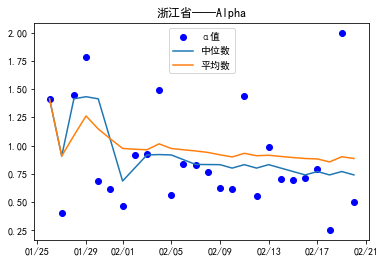

In [81]:
#提取浙江省的数据
data_zhejiang=dataf.loc[dataf['省']=='浙江省'].iloc[:,[4,8]]
data_zhejiang=data_zhejiang.iloc[::-1]
print(data_zhejiang)

#计算α值，截止到2.20日
#并同时计算α的中位数和平均值
alpha=[]
alpha_median=[]
alpha_mean=[]
data_zhejiang.iloc[0,1]
for i in range(26):
    up=log(data_zhejiang.iloc[2+i,1]/data_zhejiang.iloc[2+i-1,1])
    below=log(data_zhejiang.iloc[2+i-1,1]/data_zhejiang.iloc[2+i-2,1])
    alpha.append(up/below)
    alpha_median.append(np.median(alpha))
    alpha_mean.append(np.mean(alpha))

ax = plt.gca() 
ax.xaxis.set_major_formatter(mdate.DateFormatter('%m/%d')) 
plt.plot(pd.date_range(start='2020-1-26',periods=len(alpha),freq='1d'),alpha,"ro",label='α值',color='blue')
plt.plot(pd.date_range(start='2020-1-26',periods=len(alpha),freq='1d'),alpha_median,label='中位数')
plt.plot(pd.date_range(start='2020-1-26',periods=len(alpha),freq='1d'),alpha_mean,label='平均数')
plt.legend()
plt.title('浙江省——Alpha')
plt.savefig('figure/浙江省——Alpha.png',dpi=500)
plt.show()

In [82]:
#使用α对浙江省2月1日后的数据进行预测
zhejiang_predict=data_zhejiang.copy()
alpha_select=alpha_median[-1]
start=10
for i in range(len(zhejiang_predict)-start):
    zhejiang_predict.iloc[start+i,1]=int(pow(zhejiang_predict.iloc[start+i-1,1]/zhejiang_predict.iloc[start+i-2,1],alpha_select)*zhejiang_predict.iloc[start+i-1,1])
data_zhejiang['预测值']=zhejiang_predict.iloc[:,1]

#添加误差率和差值列
data_zhejiang.insert(loc=3,column='误差率',value=0)
data_zhejiang.insert(loc=4,column='差值',value=0)
#计算误差率和相差值
for index,data in data_zhejiang.iterrows():
    a=(data_zhejiang.loc[index,'预测值']-data_zhejiang.loc[index,'省确诊'])
    b=a/data_zhejiang.loc[index,'省确诊']
    data_zhejiang.loc[index,'误差率']=b
    data_zhejiang.loc[index,'差值']=a
data_zhejiang['误差率']=data_zhejiang['误差率'].apply(lambda x: format(x,'.2%'))
print(data_zhejiang)
data_zhejiang.to_csv('total_data/zhejiang.csv', encoding="utf_8_sig")

             日期     省确诊    预测值      误差率     差值
339  2020-01-24    43.0   43.0    0.00%    0.0
338  2020-01-25    62.0   62.0    0.00%    0.0
337  2020-01-26   104.0  104.0    0.00%    0.0
336  2020-01-27   128.0  128.0    0.00%    0.0
335  2020-01-28   173.0  173.0    0.00%    0.0
334  2020-01-29   296.0  296.0    0.00%    0.0
333  2020-01-30   428.0  428.0    0.00%    0.0
332  2020-01-31   538.0  538.0    0.00%    0.0
331  2020-02-01   599.0  599.0    0.00%    0.0
330  2020-02-02   661.0  661.0    0.00%    0.0
329  2020-02-03   724.0  711.0   -1.80%  -13.0
328  2020-02-04   829.0  750.0   -9.53%  -79.0
327  2020-02-05   895.0  780.0  -12.85% -115.0
326  2020-02-06   954.0  802.0  -15.93% -152.0
325  2020-02-07  1006.0  818.0  -18.69% -188.0
324  2020-02-08  1048.0  830.0  -20.80% -218.0
323  2020-02-09  1075.0  839.0  -21.95% -236.0
322  2020-02-10  1092.0  845.0  -22.62% -247.0
321  2020-02-11  1117.0  849.0  -23.99% -268.0
320  2020-02-12  1131.0  851.0  -24.76% -280.0
319  2020-02-

In [112]:
def MSEloss(x,y):
    result=0;
    for i in range(len(x)):
        result+=pow(x.iloc[i]-y.iloc[i],2)
    return result/len(x)

MSEloss(data_zhejiang.iloc[:,1],data_zhejiang.iloc[:,2])

56586.44117647059

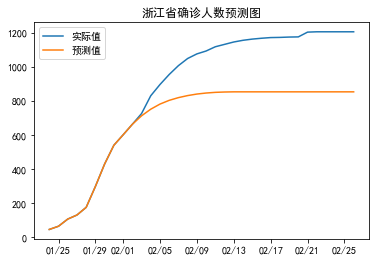

In [195]:
dates=data_zhejiang.iloc[:,0]
dates=[datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
ax = plt.gca() 
ax.xaxis.set_major_formatter(mdate.DateFormatter('%m/%d')) 
plt.plot(dates,data_zhejiang.iloc[:,1],label='实际值')
plt.plot(dates,data_zhejiang.iloc[:,2],label='预测值')
plt.title('浙江省确诊人数预测图')
plt.legend()
plt.savefig('figure/浙江省—预测图—Alpha.png',dpi=500)
plt.show()

            日期      省确诊
33  2020-01-24    549.0
32  2020-01-25    730.0
31  2020-01-26   1058.0
30  2020-01-27   1423.0
29  2020-01-28   2714.0
28  2020-01-29   3554.0
27  2020-01-30   4903.0
26  2020-01-31   5806.0
25  2020-02-01   7153.0
24  2020-02-02   9074.0
23  2020-02-03  11177.0
22  2020-02-04  13522.0
21  2020-02-05  16678.0
20  2020-02-06  19665.0
19  2020-02-07  22112.0
18  2020-02-08  24953.0
17  2020-02-09  27100.0
16  2020-02-10  29631.0
15  2020-02-11  31728.0
14  2020-02-12  33366.0
13  2020-02-13  48206.0
12  2020-02-14  51986.0
11  2020-02-15  54406.0
10  2020-02-16  56249.0
9   2020-02-17  58182.0
8   2020-02-18  59989.0
7   2020-02-19  61682.0
6   2020-02-20  62031.0
5   2020-02-21  62662.0
4   2020-02-22  63454.0
3   2020-02-23  64084.0
2   2020-02-24  64287.0
1   2020-02-25  64786.0
0   2020-02-26  65187.0


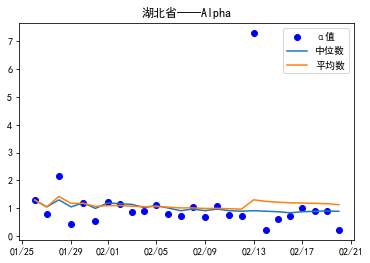

In [113]:
#提取湖北省的数据
data_hubei=dataf.loc[dataf['省']=='湖北省'].iloc[:,[4,8]]
data_hubei=data_hubei.iloc[::-1]
print(data_hubei)

#计算α值，截止到2.20日
#并同时计算α的中位数和平均值
alpha=[]
alpha_median=[]
alpha_mean=[]
data_hubei.iloc[0,1]
for i in range(26):
    up=log(data_hubei.iloc[2+i,1]/data_hubei.iloc[2+i-1,1])
    below=log(data_hubei.iloc[2+i-1,1]/data_hubei.iloc[2+i-2,1])
    alpha.append(up/below)
    alpha_median.append(np.median(alpha))
    alpha_mean.append(np.mean(alpha))

ax = plt.gca() 
ax.xaxis.set_major_formatter(mdate.DateFormatter('%m/%d')) 
plt.plot(pd.date_range(start='2020-1-26',periods=len(alpha),freq='1d'),alpha,"ro",label='α值',color='blue')
plt.plot(pd.date_range(start='2020-1-26',periods=len(alpha),freq='1d'),alpha_median,label='中位数')
plt.plot(pd.date_range(start='2020-1-26',periods=len(alpha),freq='1d'),alpha_mean,label='平均数')
plt.legend()
plt.title('湖北省——Alpha')
plt.savefig('figure/湖北省——Alpha.png',dpi=500)
plt.show()

In [196]:
alpha_median[-1]

0.7406298391682626

In [114]:
#使用α对湖北省2月13日后的数据进行预测
hubei_predict=data_hubei.copy()
alpha_select=alpha_median[-1]
start=23
for i in range(len(hubei_predict)-start):
    hubei_predict.iloc[start+i,1]=int(pow(hubei_predict.iloc[start+i-1,1]/hubei_predict.iloc[start+i-2,1],alpha_select)*hubei_predict.iloc[start+i-1,1])
data_hubei['预测值']=hubei_predict.iloc[:,1]
#添加误差率和差值列
data_hubei.insert(loc=3,column='误差率',value=0)
data_hubei.insert(loc=4,column='差值',value=0)
#计算误差率和相差值
for index,data in data_hubei.iterrows():
    a=(data_hubei.loc[index,'预测值']-data_hubei.loc[index,'省确诊'])
    b=a/data_hubei.loc[index,'省确诊']
    data_hubei.loc[index,'误差率']=b
    data_hubei.loc[index,'差值']=a
data_hubei['误差率']=data_hubei['误差率'].apply(lambda x: format(x,'.2%'))
print(data_hubei)
data_hubei.to_csv('total_data/hubei.csv', encoding="utf_8_sig")

            日期      省确诊      预测值    误差率      差值
33  2020-01-24    549.0    549.0  0.00%     0.0
32  2020-01-25    730.0    730.0  0.00%     0.0
31  2020-01-26   1058.0   1058.0  0.00%     0.0
30  2020-01-27   1423.0   1423.0  0.00%     0.0
29  2020-01-28   2714.0   2714.0  0.00%     0.0
28  2020-01-29   3554.0   3554.0  0.00%     0.0
27  2020-01-30   4903.0   4903.0  0.00%     0.0
26  2020-01-31   5806.0   5806.0  0.00%     0.0
25  2020-02-01   7153.0   7153.0  0.00%     0.0
24  2020-02-02   9074.0   9074.0  0.00%     0.0
23  2020-02-03  11177.0  11177.0  0.00%     0.0
22  2020-02-04  13522.0  13522.0  0.00%     0.0
21  2020-02-05  16678.0  16678.0  0.00%     0.0
20  2020-02-06  19665.0  19665.0  0.00%     0.0
19  2020-02-07  22112.0  22112.0  0.00%     0.0
18  2020-02-08  24953.0  24953.0  0.00%     0.0
17  2020-02-09  27100.0  27100.0  0.00%     0.0
16  2020-02-10  29631.0  29631.0  0.00%     0.0
15  2020-02-11  31728.0  31728.0  0.00%     0.0
14  2020-02-12  33366.0  33366.0  0.00% 

In [115]:
MSEloss(data_hubei.iloc[:,1],data_hubei.iloc[:,2])

3733102.382352941

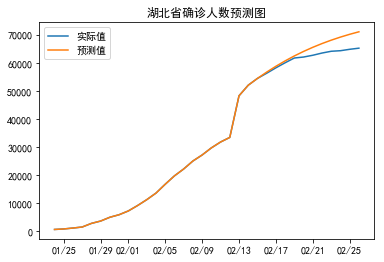

In [184]:
dates=data_hubei.iloc[:,0]
dates=[datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
ax = plt.gca() 
ax.xaxis.set_major_formatter(mdate.DateFormatter('%m/%d')) 
plt.plot(dates,data_hubei.iloc[:,1],label='实际值')
plt.plot(dates,data_hubei.iloc[:,2],label='预测值')
plt.title('湖北省确诊人数预测图')
plt.legend()
plt.savefig('figure/湖北省—预测图—Alpha.png',dpi=500)
plt.show()

In [116]:
#生成除湖北外所有省份的确诊数总和
data_except_hubei=dataf.loc[dataf['省']!='湖北省'].iloc[:,[4,8]]
date_t=dataf['日期']
date=date_t.drop_duplicates()
data_nohubei=pd.DataFrame(date)
# print(data_nohubei)
num=[]
for d in date:
    # print(d)
    temp=0;
    for index,data in data_except_hubei.loc[data_except_hubei['日期'].str.contains(d)].iterrows():
        temp+=data['省确诊']
    num.append(temp)
# print(num)
data_nohubei.insert(1,'省确诊',num)
data_nohubei=data_nohubei[::-1]
print(data_nohubei)

            日期      省确诊
33  2020-01-24    317.0
32  2020-01-25    594.0
31  2020-01-26    961.0
30  2020-01-27   1415.0
29  2020-01-28   1887.0
28  2020-01-29   2513.0
27  2020-01-30   3219.0
26  2020-01-31   3976.0
25  2020-02-01   4688.0
24  2020-02-02   5384.0
23  2020-02-03   6130.0
22  2020-02-04   6970.0
21  2020-02-05   7680.0
20  2020-02-06   8422.0
19  2020-02-07   9082.0
18  2020-02-08   9649.0
17  2020-02-09  10113.0
16  2020-02-10  10546.0
15  2020-02-11  10883.0
14  2020-02-12  11322.0
13  2020-02-13  11620.0
12  2020-02-14  11771.0
11  2020-02-15  12090.0
10  2020-02-16  12170.0
9   2020-02-17  12354.0
8   2020-02-18  12449.0
7   2020-02-19  12505.0
6   2020-02-20  12529.0
5   2020-02-21  12804.0
4   2020-02-22  12656.0
3   2020-02-23  12852.0
2   2020-02-24  12698.0
1   2020-02-25  12613.0
0   2020-02-26  12452.0


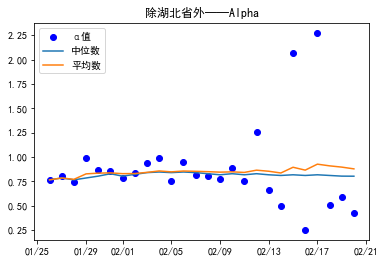

In [117]:
#计算α值，截止到2.20日
#并同时计算α的中位数和平均值
alpha=[]
alpha_median=[]
alpha_mean=[]
for i in range(26):
    up=log(data_nohubei.iloc[2+i,1]/data_nohubei.iloc[2+i-1,1])
    below=log(data_nohubei.iloc[2+i-1,1]/data_nohubei.iloc[2+i-2,1])
    alpha.append(up/below)
    alpha_median.append(np.median(alpha))
    alpha_mean.append(np.mean(alpha))

ax = plt.gca() 
ax.xaxis.set_major_formatter(mdate.DateFormatter('%m/%d')) 
plt.plot(pd.date_range(start='2020-1-26',periods=len(alpha),freq='1d'),alpha,"ro",label='α值',color='blue')
plt.plot(pd.date_range(start='2020-1-26',periods=len(alpha),freq='1d'),alpha_median,label='中位数')
plt.plot(pd.date_range(start='2020-1-26',periods=len(alpha),freq='1d'),alpha_mean,label='平均数')
plt.legend()
plt.title('除湖北省外——Alpha')
plt.savefig('figure/除湖北省外——Alpha.png',dpi=500)
plt.show()

In [118]:
#使用α对除湖北省外2月13日后的数据进行预测
hubei_predict=data_nohubei.copy()
alpha_select=alpha_median[-1]
start=23
for i in range(len(hubei_predict)-start):
    hubei_predict.iloc[start+i,1]=int(pow(hubei_predict.iloc[start+i-1,1]/hubei_predict.iloc[start+i-2,1],alpha_select)*hubei_predict.iloc[start+i-1,1])
data_nohubei['预测值']=hubei_predict.iloc[:,1]
#添加误差率和差值列
# data_nohubei.insert(loc=3,column='误差率',value=0)
# data_nohubei.insert(loc=4,column='差值',value=0)
#计算误差率和相差值
for index,data in data_nohubei.iterrows():
    a=(data_nohubei.loc[index,'预测值']-data_nohubei.loc[index,'省确诊'])
    b=a/data_nohubei.loc[index,'省确诊']
    data_nohubei.loc[index,'误差率']=b
    data_nohubei.loc[index,'差值']=a
data_nohubei['误差率']=data_nohubei['误差率'].apply(lambda x: format(x,'.2%'))
print(data_nohubei)
data_nohubei.to_csv('total_data/nohubei.csv', encoding="utf_8_sig")

            日期      省确诊      预测值    误差率     差值
33  2020-01-24    317.0    317.0  0.00%    0.0
32  2020-01-25    594.0    594.0  0.00%    0.0
31  2020-01-26    961.0    961.0  0.00%    0.0
30  2020-01-27   1415.0   1415.0  0.00%    0.0
29  2020-01-28   1887.0   1887.0  0.00%    0.0
28  2020-01-29   2513.0   2513.0  0.00%    0.0
27  2020-01-30   3219.0   3219.0  0.00%    0.0
26  2020-01-31   3976.0   3976.0  0.00%    0.0
25  2020-02-01   4688.0   4688.0  0.00%    0.0
24  2020-02-02   5384.0   5384.0  0.00%    0.0
23  2020-02-03   6130.0   6130.0  0.00%    0.0
22  2020-02-04   6970.0   6970.0  0.00%    0.0
21  2020-02-05   7680.0   7680.0  0.00%    0.0
20  2020-02-06   8422.0   8422.0  0.00%    0.0
19  2020-02-07   9082.0   9082.0  0.00%    0.0
18  2020-02-08   9649.0   9649.0  0.00%    0.0
17  2020-02-09  10113.0  10113.0  0.00%    0.0
16  2020-02-10  10546.0  10546.0  0.00%    0.0
15  2020-02-11  10883.0  10883.0  0.00%    0.0
14  2020-02-12  11322.0  11322.0  0.00%    0.0
13  2020-02-1

In [119]:
MSEloss(data_nohubei.iloc[:,1],data_nohubei.iloc[:,2])

75565.35294117648

In [201]:
alpha_select

0.8034540692872902

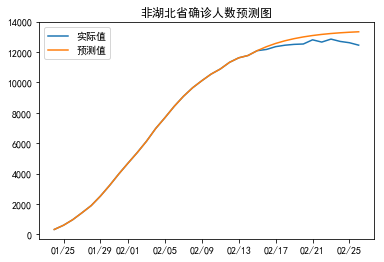

In [200]:
dates=data_nohubei.iloc[:,0]
dates=[datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
ax = plt.gca() 
ax.xaxis.set_major_formatter(mdate.DateFormatter('%m/%d')) 
plt.plot(dates,data_nohubei.iloc[:,1],label='实际值')
plt.plot(dates,data_nohubei.iloc[:,2],label='预测值')
plt.title('非湖北省确诊人数预测图')
plt.legend()
plt.savefig('figure/非湖北省—预测图—Alpha.png',dpi=500)
plt.show()

In [15]:
#生成各省死亡，治愈，确诊总和的txt
data_path='allsum_data//'
data_zhejiang=dataf.loc[dataf['省']=='浙江省'].iloc[:,[4,6,7,8]]
data_zhejiang=data_zhejiang.iloc[::-1]
data_zhejiang=data_zhejiang.drop('日期',axis=1)
data_zhejiang.to_csv(data_path+'data_zhejiang_2.26.txt', header=0,index=False)

In [16]:
#生成除湖北外所有省份的死亡，治愈，确诊数总和
data_except_hubei=dataf.loc[dataf['省']!='湖北省'].iloc[:,[4,8]]
date_t=dataf['日期']
date=date_t.drop_duplicates()
data_nohubei=pd.DataFrame(date)
# print(data_nohubei)
siwang=[]
zhiyu=[]
quezhen=[]

for d in date:
    # print(d)
    a=0;
    b=0;
    c=0
    for index,data in data_except_hubei.loc[data_except_hubei['日期'].str.contains(d)].iterrows():
        a+=data['省死亡']
        b+=data['省治愈']
        c+=data['省确诊']
    siwang.append(a)
    zhiyu.append(b)
    quezhen.append(c)
# print(num)
data_nohubei.insert(1,'省死亡',siwang)
data_nohubei.insert(2,'省治愈',zhiyu)
data_nohubei.insert(3,'省确诊',quezhen)
data_nohubei=data_nohubei[::-1]
print(data_nohubei)
data_nohubei=data_nohubei.drop('日期',axis=1)
data_nohubei.to_csv(data_path+'data_nohubei_2.26.txt', header=0,index=False)


            日期   省死亡     省治愈      省确诊
33  2020-01-24   2.0     4.0    317.0
32  2020-01-25   2.0     8.0    594.0
31  2020-01-26   3.0     7.0    961.0
30  2020-01-27   6.0    12.0   1415.0
29  2020-01-28   7.0    21.0   1887.0
28  2020-01-29   8.0    32.0   2513.0
27  2020-01-30   9.0    51.0   3219.0
26  2020-01-31   9.0    82.0   3976.0
25  2020-02-01  11.0   107.0   4688.0
24  2020-02-02  11.0   175.0   5384.0
23  2020-02-03  11.0   228.0   6130.0
22  2020-02-04  11.0   321.0   6970.0
21  2020-02-05  13.0   487.0   7680.0
20  2020-02-06  14.0   659.0   8422.0
19  2020-02-07  18.0   881.0   9082.0
18  2020-02-08  25.0  1159.0   9649.0
17  2020-02-09  32.0  1417.0  10113.0
16  2020-02-10  37.0  1692.0  10546.0
15  2020-02-11  42.0  1984.0  10883.0
14  2020-02-12  47.0  2381.0  11322.0
13  2020-02-13  57.0  2760.0  11620.0
12  2020-02-14  61.0  3135.0  11771.0
11  2020-02-15  66.0  3666.0  12090.0
10  2020-02-16  69.0  4041.0  12170.0
9   2020-02-17  75.0  4571.0  12354.0
8   2020-02-

In [131]:
a=pd.read_csv('allsum_data/data_hubei_2.26.txt', encoding='UTF-8',header=None)
print(a)
a.iloc[:,2].to_csv('allsum_data/quezhen_hubei_2.26.txt', header=0,index=False)

         0        1        2
0     24.0     31.0    549.0
1     39.0     32.0    730.0
2     52.0     42.0   1058.0
3     76.0     47.0   1423.0
4    100.0     52.0   2714.0
5    125.0     87.0   3554.0
6    162.0     90.0   4903.0
7    204.0    141.0   5806.0
8    249.0    168.0   7153.0
9    294.0    267.0   9074.0
10   350.0    300.0  11177.0
11   414.0    398.0  13522.0
12   479.0    537.0  16678.0
13   549.0    712.0  19665.0
14   618.0    867.0  22112.0
15   699.0   1218.0  24953.0
16   780.0   1480.0  27100.0
17   871.0   1854.0  29631.0
18   974.0   2310.0  31728.0
19  1068.0   2686.0  33366.0
20  1310.0   3459.0  48206.0
21  1426.0   4131.0  51986.0
22  1457.0   4821.0  54406.0
23  1596.0   5666.0  56249.0
24  1696.0   6693.0  58182.0
25  1789.0   7943.0  59989.0
26  1921.0   9336.0  61682.0
27  2029.0  10521.0  62031.0
28  2144.0  11881.0  62662.0
29  2250.0  13690.0  63454.0
30  2346.0  15343.0  64084.0
31  2495.0  16748.0  64287.0
32  2563.0  18971.0  64786.0
33  2615.0  20

In [143]:
dat = np.loadtxt('allsum_data/quezhen_hubei_2.26.txt',delimiter=',')
dat=np.expand_dims(dat,axis=1)
print(dat.shape)

(34, 1)
